In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import networkx as nx
import torch
import torch_geometric as tg

from models.attention_network import GraphAttentionNetwork, TestAttentionNetwork
from utils.transforms import EuclideanInformationTransform, OneHot

import e3nn

#### Create a test for the Attention Mechanism specifically

In [33]:
def test_K(edge_index, node_features, edge_features):
    return edge_features

def test_Q(node_features):
    return node_features

# value messages are computed PER EDGE
def test_V(edge_index, node_features, edge_features):
    return torch.ones(size=(edge_index.shape[1], 2))

In [34]:
self_loop_value = 2.0

In [35]:
gan = TestAttentionNetwork(test_K, test_Q, test_V, self_loop_attention_value=self_loop_value)

In [36]:
g = nx.DiGraph()
vertices = (0, 1, 2, 3)
edges = [(1, 0),
         (2, 0),
         (0, 1),
         (1, 2),
         ]

node_features = ([1., 0.],
                  [0., 0.],
                  [2., 0.],
                  [1874., 666.]
                  )

edge_features = ([1., 0.],
                  [0., 1.],
                  [1., 1.],
                  [1., 0.],
                  )

node_features = {v: {'node_features': torch.tensor(node_features[i])} for i, v in enumerate(vertices)}
edge_features = {e: {'edge_features': torch.tensor(edge_features[i])} for i, e in enumerate(edges)}

g = nx.DiGraph()
for v in vertices:
    g.add_node(v)
for e in edges:
    g.add_edge(*e)

nx.set_node_attributes(g, node_features)
nx.set_edge_attributes(g, edge_features)
graph = tg.utils.from_networkx(g)

In [37]:
test_alphas = gan.compute_alpha(graph.edge_index, graph.edge_features, graph.node_features, self_loop_attention_value=gan.self_loop_attention_value)

In [38]:
test_alphas

tensor([[2., 1., 0., 0.],
        [0., 2., 0., 0.],
        [0., 2., 2., 0.],
        [0., 0., 0., 2.]])

In [39]:
# Define tests
assert (test_alphas[0, :] == torch.tensor([self_loop_value, 1., 0., 0.])).all()
assert (test_alphas[1, :] == torch.tensor([0., self_loop_value, 0., 0.])).all() # Has a zero query vector
assert (test_alphas.diag() == torch.tensor([self_loop_value]*4)).all() # Filled diagonal elements
assert (test_alphas[2, :] == torch.tensor([0.0, 2.0, self_loop_value, 0.])).all() # Only has one neighbour
assert (test_alphas[3, :] == torch.tensor([0., 0., 0., self_loop_value])).all() # No neighbours

In [47]:
out = gan.forward(graph.edge_index,
            graph.node_features,
            graph.edge_features
            )

torch.Size([8, 2])
tensor([[0, 1, 1, 2, 0, 1, 2, 3],
        [1, 0, 2, 0, 0, 1, 2, 3]])
torch.Size([2, 8])


In [52]:
out[:graph.node_features.shape[0]]

tensor([[3., 3.],
        [2., 2.],
        [4., 4.],
        [2., 2.]])

In [53]:
test_alphas

tensor([[2., 1., 0., 0.],
        [0., 2., 0., 0.],
        [0., 2., 2., 0.],
        [0., 0., 0., 2.]])

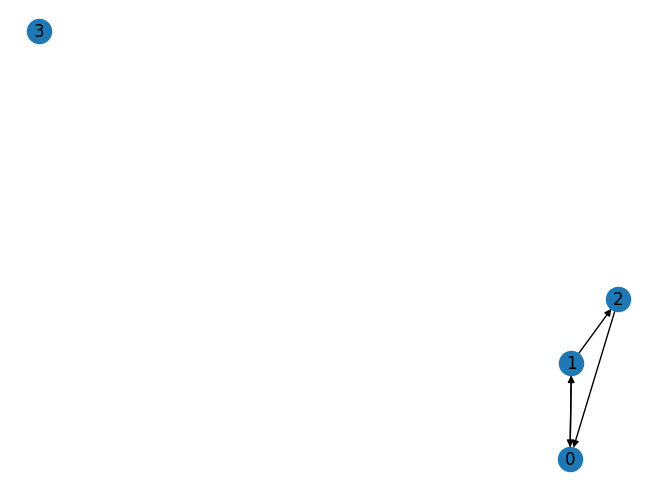

In [46]:
nx.draw(g, with_labels=True)

### Create a test to see that everything works end to end

In [ ]:

g = nx.DiGraph()

vertices = (0, 1, 2, 3)
edges = [(0, 1),
         (1, 2),
         (2, 0),
         (2, 3),
         (3, 0)
         ]
z = [0, 1, 2, 1]
pos = [(0.,   0.,  0.),
       (-1., -1., -1.),
       (1.,   1.,  1.),
       (2.,   2.,  2.),
     ]

features = {i: {'z': z[i], 'pos': pos[i]} for i in vertices }

for v in vertices:
    g.add_node(v)

for e in edges:
    g.add_edge(*e)

nx.set_node_attributes(g, features)

graph = tg.utils.from_networkx(g)

euc_transform = EuclideanInformationTransform()
one_hot_transform = OneHot('z', 'z')
transform = tg.transforms.Compose([euc_transform, one_hot_transform])

graph = transform(graph)


In [ ]:
test_dataloader = tg.data.DataLoader([graph, graph.clone()], batch_size=1)
for batch in test_dataloader:
    break

In [ ]:
feature_irreps = e3nn.o3.Irreps("10x0e + 10x1e + 10x2e")
geometric_irreps = e3nn.o3.Irreps("3x0e+3x1e+3x2e")
output_irreps = e3nn.o3.Irreps("10x0e + 10x1e + 10x2e")
internal_key_query_irreps = e3nn.o3.Irreps("5x0e + 5x1e + 5x2e")

K = RadiallyParamaterisedTensorProduct(feature_irreps,
                                      geometric_irreps,
                                      internal_key_query_irreps,
                                      radial_hidden_units=16
                                      )
Q = QueryNetwork(feature_irreps,
                 internal_key_query_irreps)

V = RadiallyParamaterisedTensorProduct(feature_irreps,
                                       geometric_irreps,
                                       output_irreps,
                                       radial_hidden_units=16)


embed = torch.nn.Linear(batch.z.shape[1], feature_irreps.dim)
features = embed(batch.z.float())
edge_harmonics = e3nn.o3.spherical_harmonics(geometric_irreps,
                                             batch.relative_positions,
                                             normalize=False)

tt = ToyTransformer(Q=Q, K=K, V=V)



In [ ]:
# Code to derive the edge features
weights = K.radial_net(batch.distances)
source_indices = batch.edge_index[0, :]
source_features = features[source_indices]

k_uv = K.tensor_product(source_features,
                 edge_harmonics,
                 weights)

In [ ]:
(K(source_features, edge_harmonics, batch.distances) == k_uv).all()

In [ ]:
# One row for each node
q = Q.forward(features)
print(q.shape) # a query vector for each node)

###

In [ ]:
k_uv.shape # A key vector for each edge

In [ ]:
dots = q @ k_uv.T # Matrix multiplication gives us a number of nodes * number of edges matrix
                  # This isn't actually ideal because you waste a few computations

In [ ]:
k_uv.shape

In [ ]:
targets = batch.edge_index[1, :]
targets

In [ ]:
k_uv.shape

In [ ]:
edge_index = batch.edge_index

alphas = torch.zeros((dots.shape[0], dots.shape[0]))
for node in range(dots.shape[0]): # iterate through the nodes
    # This gets the indices of the
    neighbourhood_edge_indices = (edge_index[1,:] == node).nonzero() # Finds the indices of the edges for which this node is a target.
    neighbourhood_edge_indices = neighbourhood_edge_indices.flatten()

    neighbourhood_k = k_uv[neighbourhood_edge_indices, :] # Get all k in this neighbourhood
    q_node = q[node]

    neighbourhood_dot = q_node @ neighbourhood_k.T # Matrix multiplication
    neighbourhood_alphas = torch.nn.functional.softmax(neighbourhood_dot, dim=0)

    # Now, use the edges to store the alphas at the correct points
    neighbourhood_edges = edge_index[:, neighbourhood_edge_indices]
    source_nodes = neighbourhood_edges[0, :]
    alphas[node, source_nodes] = neighbourhood_alphas

# Finally, we force an attention coefficient from each node to itself
diagonal_indices = torch.arange(0, alphas.shape[0])
alphas[diagonal_indices, diagonal_indices] = 1.

In [ ]:
alphas

In [ ]:
torch.nn.functional.softmax(neighbourhood_dot, dim=0)

In [ ]:
diagonal_indices = torch.arange(0, )

In [ ]:
alphas

In [ ]:
q_node.shape

In [ ]:
neighbourhood_edge_indices

In [ ]:
neighbourhood_edges

In [ ]:
alphas = torch.zeros((dots.shape[0], dots.shape[0]))

In [ ]:
alphas[neighbourhood_edges[1, :], neighbourhood_edges[0, :]] = 1.0

In [ ]:
alphas

In [ ]:
# Need to fill these in POST softmax
alpha = torch.zeros((q.shape[0], q.shape[0]))


In [ ]:
for source, target in batch.edge_index.T:
    alpha[target, source] = dots

In [ ]:
batch.edge_index